In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast


# For the Radon transform
from skimage.transform import radon
from skimage.draw import disk, ellipse


# Dataset is built up

c:\Users\fangy\miniconda3\lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


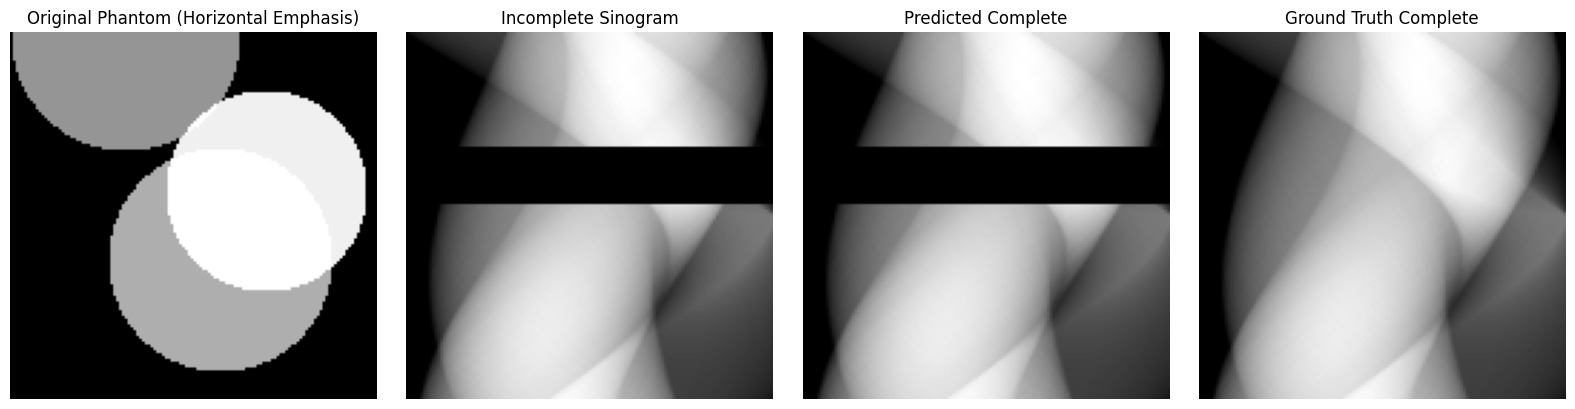

In [2]:
# Redefine the generate_random_phantom function with horizontal emphasis

from skimage.draw import disk, ellipse
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon

def generate_random_phantom(size=128, max_shapes=5):
    """
    Generate a random phantom image of given `size x size`,
    containing up to `max_shapes` circles or ellipses,
    with shapes aligned horizontally to produce horizontal bands in the sinogram.
    """
    image = np.zeros((size, size), dtype=np.float32)
    
    num_shapes = np.random.randint(1, max_shapes + 1)
    for _ in range(num_shapes):
        shape_type = np.random.choice(["circle", "ellipse"])
        
        # Ensure horizontal alignment
        center_x = np.random.randint(size // 4, 3 * size // 4)  # Restrict horizontal spread
        center_y = np.random.randint(0, size)  # Full vertical range
        
        # Random radii
        radius_x = np.random.randint(5, size // 6)  # Horizontal spread is limited
        radius_y = np.random.randint(size // 6, size // 3)  # Vertical spread is larger
        
        intensity = np.random.uniform(0.5, 1.0)
        
        if shape_type == "circle":
            rr, cc = disk((center_y, center_x), radius_y)  # Use larger vertical radius for horizontal emphasis
            rr = np.clip(rr, 0, image.shape[0] - 1)
            cc = np.clip(cc, 0, image.shape[1] - 1)
            image[rr, cc] += intensity
        else:
            rr, cc = ellipse(center_y, center_x, radius_y, radius_x, shape=image.shape)
            image[rr, cc] += intensity
    
    # Clip to [0,1] for safety
    image = np.clip(image, 0, 1)
    return image

# Generate updated phantom with horizontal emphasis
updated_phantom = generate_random_phantom(size=128, max_shapes=5)

# Generate sinogram
theta = np.linspace(0., 180., max(updated_phantom.shape), endpoint=False)
sinogram = radon(updated_phantom, theta=theta, circle=True)
incomplete_sinogram = sinogram.copy()
incomplete_sinogram[:, 40:60] = 0  # Simulate missing data

# Transpose for horizontal alignment
sinogram = sinogram.T
incomplete_sinogram = incomplete_sinogram.T

# Visualization
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Original Phantom
axs[0].imshow(updated_phantom, cmap='gray')
axs[0].set_title('Original Phantom (Horizontal Emphasis)')
axs[0].axis('off')

# Incomplete Sinogram
axs[1].imshow(incomplete_sinogram, cmap='gray')
axs[1].set_title('Incomplete Sinogram')
axs[1].axis('off')

# Placeholder Predicted Sinogram (using incomplete as placeholder)
predicted_sinogram = incomplete_sinogram.copy()
axs[2].imshow(predicted_sinogram, cmap='gray')
axs[2].set_title('Predicted Complete')
axs[2].axis('off')

# Ground Truth Sinogram
axs[3].imshow(sinogram, cmap='gray')
axs[3].set_title('Ground Truth Complete')
axs[3].axis('off')

plt.tight_layout()
plt.show()

In [3]:
def create_incomplete_sinogram(image, angles=None, missing_row_start=40, missing_row_end=60):
    """
    Takes a 2D image, performs radon transform, and zeroes out
    rows [missing_row_start : missing_row_end] to simulate an incomplete sinogram with horizontal bands.
    """
    if angles is None:
        angles = np.linspace(0., 180., max(image.shape), endpoint=False)
        
    # Perform Radon transform (sinogram shape: [projections, angles])
    sinogram = radon(image, theta=angles, circle=False)
    
    # Transpose for horizontal alignment (shape becomes: [angles, projections])
    sinogram = sinogram.T
    
    # Create an incomplete version by zeroing out a horizontal region
    incomplete = sinogram.copy()
    incomplete[missing_row_start:missing_row_end, :] = 0.0  # Zero out rows instead of columns
    
    return sinogram, incomplete

In [4]:
class SinogramDataset(Dataset):
    def __init__(self, size=128, num_samples=1000, missing_row_start=40, missing_row_end=60):
        super().__init__()
        self.size = size
        self.num_samples = num_samples
        self.missing_row_start = missing_row_start
        self.missing_row_end = missing_row_end
        
        # Precompute angles for Radon transform
        self.angles = np.linspace(0., 180., self.size, endpoint=False)

    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Generate a random phantom
        phantom = generate_random_phantom(self.size)
        complete_sino, incomplete_sino = create_incomplete_sinogram(
            phantom, 
            angles=self.angles,
            missing_row_start=self.missing_row_start, 
            missing_row_end=self.missing_row_end
        )
        
        # Convert to PyTorch tensors
        # [1, H, W] shape for CNN usage
        complete_sino_t = torch.tensor(complete_sino, dtype=torch.float32).unsqueeze(0)
        incomplete_sino_t = torch.tensor(incomplete_sino, dtype=torch.float32).unsqueeze(0)
        
        return incomplete_sino_t, complete_sino_t


# Model

In [5]:
class DoubleConv(nn.Module):
    """(convolution => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Down part
        current_channels = in_channels
        for f in features:
            self.downs.append(DoubleConv(current_channels, f))
            current_channels = f
        
        # Up part
        for f in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(f * 2, f, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(f * 2, f))
        
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        # Add padding dynamically to make the input dimensions even
        pad_y = (x.shape[2] % 2 != 0)
        pad_x = (x.shape[3] % 2 != 0)
        if pad_y or pad_x:
            x = F.pad(x, (0, int(pad_x), 0, int(pad_y)))
        
        skip_connections = []
        
        # Down sampling
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        # Up sampling
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx // 2]
            
            # Handle size mismatch
            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:])
            
            x = torch.cat([x, skip], dim=1)
            x = self.ups[idx + 1](x)
        
        return self.final_conv(x)


# Train model

In [6]:
def train_model(
    model, 
    dataloader, 
    epochs=5, 
    lr=1e-3
):
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model.to(device)
    scaler = GradScaler()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for incomplete_sino, complete_sino in dataloader:
            incomplete_sino = incomplete_sino.to(device)
            complete_sino = complete_sino.to(device)
            optimizer.zero_grad()
            # Forward
            with autocast():
                output = model(incomplete_sino)
                loss = criterion(output, complete_sino)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()            
            
            epoch_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader):.5f}")

# Main

In [ ]:
# Hyperparameters
IMG_SIZE = 128
BATCH_SIZE = 64
NUM_SAMPLES = 200  # For demonstration
EPOCHS = 20

# Select Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

# Create dataset and dataloader
dataset = SinogramDataset(size=IMG_SIZE, num_samples=NUM_SAMPLES, 
                            missing_row_start=40, missing_row_end=60)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

# Initialize model
model = UNet(in_channels=1, out_channels=1)
model.to(device)

# Train
train_model(model, dataloader, epochs=EPOCHS, lr=1e-3)

# Test on a random sample
model.eval()
with torch.no_grad():
    incomplete_sino, complete_sino = dataset[0]
    incomplete_sino = incomplete_sino.unsqueeze(0).to(device)  # Add batch dimension
    output = model(incomplete_sino)

# Convert to numpy for visualization (move tensors back to CPU)
incomplete_sino_np = incomplete_sino.squeeze().cpu().numpy()
complete_sino_np = complete_sino.squeeze().numpy()
output_np = output.squeeze().cpu().numpy()

# Visualize
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(incomplete_sino_np, cmap='gray')
ax[0].set_title("Incomplete Sinogram")
ax[1].imshow(output_np, cmap='gray')
ax[1].set_title("Predicted Complete")
ax[2].imshow(complete_sino_np, cmap='gray')
ax[2].set_title("Ground Truth Complete")
plt.show()


Training on device: cuda
Using device: cuda
